In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta as td
from scipy.integrate import simpson, cumtrapz
import os

import DEBpython.pet as pet
import DEBpython.models as models
from DEBpython.visualizer import tex_par_symbols, tex_par_units, par_descriptions_en
import DEBpython.composition as composition
import DEBpython.formulae as formulae
import DEBpython.efficiency as efficiency

from DEBtoolPyIF.data_sources import *
from DEBtoolPyIF.notebook_visualizers import *

from run_multitier_estimation import create_tier_structure

sns.set_style('ticks')
%matplotlib inline

# Setup

## Load tier structure

In [3]:
multitier = create_tier_structure()


## Auxiliary variables

In [4]:
data_type_labels = {
    'tW': 'Weight',
    'tJX': 'Feed intake',
    'avg': 'All',
}
par_order = ['p_Am', 'kap_X', 'p_M', 'v', 'kap']
def estim_sort_key(estim):
    params = estim.split()
    return (len(params), [par_order.index(param) for param in params])

n_digits = {'p_Am': 0, 'kap_X': 3, 'p_M': 1, 'v': 3, 'kap': 3, 'E_G':0, 'del_M': 3, 't_0': 0, 'p_Am_f': 0}

# p_Am_f
tex_par_units['p_Am_f'] = tex_par_units['p_Am']
tex_par_symbols['p_Am_f'] = r'_f\!' + tex_par_symbols['p_Am']
par_descriptions_en['p_Am_f'] = par_descriptions_en['p_Am'] + ' for females'
# E_Hx_f
tex_par_units['E_Hx_f'] = tex_par_units['E_Hx']
tex_par_symbols['E_Hx_f'] = r'_f\!' + tex_par_symbols['E_Hx']
par_descriptions_en['E_Hx_f'] = par_descriptions_en['E_Hx'] + ' for females'
# E_Hp_f
tex_par_units['E_Hp_f'] = tex_par_units['E_Hp']
tex_par_symbols['E_Hp_f'] = r'_f\!' + tex_par_symbols['E_Hp']
par_descriptions_en['E_Hp_f'] = par_descriptions_en['E_Hp'] + ' for females'

In [5]:
heatmap_par_labels = [f'${tex_par_symbols[p]}$' for p in par_order]
heatmap_bounds = (7.5, 12)
colormap = 'cividis'

In [6]:
non_estimated_pars = {'k_J': 0.002, 'kap_R': 0.95, 'T': 311.75}

## Auxiliary functions

In [7]:
def compute_deviation(val, ref):
    return (val - ref) / ref

In [8]:
def set_in_bold_if_lower(text, val, ref):
    if not len(text):
        return text
    if val < ref:
        return r'\textbf{' + text + r'}'
    return text

In [38]:
def seconds_to_time(seconds):
    return str(td(seconds=round(seconds)))

# Estimation Results Tables

## Breed tier

In [9]:
multitier.tiers['breed'].load_results()
breed_tier = multitier.tiers['breed']

### Breed data errors

In [10]:
breed_data_errors = pd.read_csv(f"{breed_tier.output_folder}/breed_extra_data_errors.csv", index_col='data')

names_sources_units_list = [
    ['Gestation time', '\\cite{quaresma_twinning_2004}', '$\\mathrm{d}$'],
    ['Lifespan', '\\cite{bettencourt_atuacao_2021}', '$\\mathrm{year}$'],
    ['Maximum reproduction rate', '\\cite{acbm_associacao_2023}', '$\\mathrm{calves/d}$'],
    ['Time since birth at weaning for females', '\\cite{acbm_associacao_2023}', '$\\mathrm{d}$'],
    ['Time since birth at puberty for females', '\\cite{acbm_associacao_2023}', '$\\mathrm{d}$'],
    ['Maximum withers height for males', '\\cite{fao_domestic_2023}', '$\\mathrm{cm}$'],
    ['Wet weight at birth for females', '\\cite{quaresma_twinning_2004}', '$\\mathrm{kg}$'],
    ['Wet weight at weaning for females', '\\cite{carolino_racbovina_2020}', '$\\mathrm{kg}$'],
    ['Wet weight at puberty for females', 'Expert knowledge', '$\\mathrm{kg}$'],
    ['Maximum wet weight for females', '\\cite{fao_domestic_2023}', '$\\mathrm{kg}$'],
    ['Time since birth at weaning for males', '\\cite{acbm_associacao_2023}', '$\\mathrm{d}$'],
    ['Time since birth at puberty for males', '\\cite{monteiro_intramuscular_2012}', '$\\mathrm{d}$'],
    ['Maximum withers height for males', '\\cite{fao_domestic_2023}', '$\\mathrm{cm}$'],
    ['Wet weight at birth for males', '\\cite{quaresma_twinning_2004}', '$\\mathrm{kg}$'],
    ['Wet weight at weaning for males', '\\cite{carolino_racbovina_2020}', '$\\mathrm{kg}$'],
    ['Wet weight at puberty for males', 'Expert knowledge', '$\\mathrm{kg}$'],
    ['Maximum wet weight for males', '\\cite{fao_domestic_2023}', '$\\mathrm{kg}$'],
]
names_sources_units = pd.DataFrame(names_sources_units_list, columns=['name', 'source', 'unit'],
                                   index=breed_data_errors.index)
breed_data_errors = breed_data_errors.join(names_sources_units)

breed_data_errors['error'] *= 100
breed_data_errors['error'] = breed_data_errors['error'].apply(lambda x: f"{x:.1f}\%")
for dt in breed_data_errors.index.values:
    if 'kg' in breed_data_errors.loc[dt, 'unit']:
        breed_data_errors.loc[dt, 'value'] /= 1000
        breed_data_errors.loc[dt, 'prediction'] /= 1000
    if 'year' in breed_data_errors.loc[dt, 'unit']:
        breed_data_errors.loc[dt, 'value'] /= 365
        breed_data_errors.loc[dt, 'prediction'] /= 365
    # Get how many decimal places are in value
    str_value_spl = str(breed_data_errors.loc[dt, 'value']).split('.')[1]
    n_decimals = len(str_value_spl)
    if str_value_spl == '0':
        n_decimals = 0
    if len(str_value_spl) > 1:
        n_decimals = 4
    breed_data_errors.loc[dt, 'value'] = f"{breed_data_errors.loc[dt, 'value']:.{n_decimals}f}"
    breed_data_errors.loc[dt, 'prediction'] = f"{breed_data_errors.loc[dt, 'prediction']:.{n_decimals}f}"
breed_data_errors.head()


,value,prediction,error,name,source,unit
data,,,,,,
ab,284,276,2.9\%,Gestation time,\cite{quaresma_twinning_2004},$\mathrm{d}$
am,20,20,0.0\%,Lifespan,\cite{bettencourt_atuacao_2021},$\mathrm{year}$
Ri,0.0022,0.0022,0.2\%,Maximum reproduction rate,\cite{acbm_associacao_2023},$\mathrm{calves/d}$
tx_f,210,223,6.3\%,Time since birth at weaning for females,\cite{acbm_associacao_2023},$\mathrm{d}$
tp_f,288.9583,314.4400,8.8\%,Time since birth at puberty for females,\cite{acbm_associacao_2023},$\mathrm{d}$


In [11]:
for dt in breed_data_errors.index.values:
    print(f"{breed_data_errors.loc[dt, 'name']} & "
          f"{breed_data_errors.loc[dt, 'source']} & "
          f"{breed_data_errors.loc[dt, 'value']} & "
          f"{breed_data_errors.loc[dt, 'prediction']} & "
          f"{breed_data_errors.loc[dt, 'error']} & "
          f"{breed_data_errors.loc[dt, 'unit']} \\\\")

Gestation time & \cite{quaresma_twinning_2004} & 284 & 276 & 2.9\% & $\mathrm{d}$ \\
Lifespan & \cite{bettencourt_atuacao_2021} & 20 & 20 & 0.0\% & $\mathrm{year}$ \\
Maximum reproduction rate & \cite{acbm_associacao_2023} & 0.0022 & 0.0022 & 0.2\% & $\mathrm{calves/d}$ \\
Time since birth at weaning for females & \cite{acbm_associacao_2023} & 210 & 223 & 6.3\% & $\mathrm{d}$ \\
Time since birth at puberty for females & \cite{acbm_associacao_2023} & 288.9583 & 314.4400 & 8.8\% & $\mathrm{d}$ \\
Maximum withers height for males & \cite{fao_domestic_2023} & 155 & 150 & 3.1\% & $\mathrm{cm}$ \\
Wet weight at birth for females & \cite{quaresma_twinning_2004} & 46 & 47 & 3.2\% & $\mathrm{kg}$ \\
Wet weight at weaning for females & \cite{carolino_racbovina_2020} & 155.4 & 142.5 & 8.3\% & $\mathrm{kg}$ \\
Wet weight at puberty for females & Expert knowledge & 205 & 183 & 10.7\% & $\mathrm{kg}$ \\
Maximum wet weight for females & \cite{fao_domestic_2023} & 400 & 447 & 11.8\% & $\mathrm{kg}$ \\

### Individual data errors

In [12]:
breed_tier.ind_data_errors['avg'] = np.mean(breed_tier.ind_data_errors[['tJX', 'tW']], axis=1)
breed_tier.ind_data_errors

for data_type, data_type_name in data_type_labels.items():
    print(f"{data_type_name} & "
          f"{breed_tier.ind_data_errors[data_type].mean()*100:.1f} $\\pm$ "
          f"{breed_tier.ind_data_errors[data_type].std()*100:.1f} \\% \\\\")    

Weight & 7.4 $\pm$ 2.2 \% \\
Feed intake & 16.1 $\pm$ 6.5 \% \\
All & 11.7 $\pm$ 3.0 \% \\


In [13]:
breed_tier.tier_errors['avg'] = np.mean(breed_tier.tier_errors[['tJX', 'tW']], axis=1)
breed_tier.tier_errors

,estim_time,tJX,tW,avg
tier_sample,,,,
male,1189.908154,0.160771,0.074192,0.117482


### Parameters

In [14]:
breed_pars_df = breed_tier.pars_df.loc['male']
for par in breed_pars_df.index:
    if par in n_digits:
        formatted_value = f"{breed_pars_df[par]:.{n_digits[par]}f}"
    else:
        formatted_value = f"{breed_pars_df[par]:.3e}"
    print(f"${tex_par_symbols[par]}$ & "
          f"{par_descriptions_en[par]} & " 
          f"\\num{{{formatted_value}}} & "
          f"\\unit{{{tex_par_units[par]}}} \\\\")


$\{\dot{p}_{Am}\}$ & Surface-specific maximum assimilation rate & \num{4313} & \unit{J/d \cdot cm^2} \\
$\kappa_X$ & Digestion efficiency & \num{0.116} & \unit{-} \\
$[\dot{p}_M]$ & Volume-specific somatic maintenance rate & \num{106.0} & \unit{J/d \cdot cm^3} \\
$\dot{v}$ & Energy conductance & \num{0.049} & \unit{cm/d} \\
$\kappa$ & Allocation fraction to soma & \num{0.926} & \unit{-} \\
$[E_G]$ & Specific cost of structure & \num{7836} & \unit{J/cm^3} \\
$E_H^b$ & Maturity at birth & \num{7.208e+06} & \unit{J} \\
$E_H^x$ & Maturity at weaning & \num{3.925e+07} & \unit{J} \\
$E_H^p$ & Maturity at puberty & \num{7.224e+07} & \unit{J} \\
$\ddot{h}_a$ & Weibull aging acceleration & \num{7.161e-08} & \unit{d^{-2}} \\
$t_0$ & Diapause & \num{88} & \unit{d} \\
$\delta_M$ & Shape coefficient & \num{0.221} & \unit{-} \\
$_f\!\{\dot{p}_{Am}\}$ & Surface-specific maximum assimilation rate for females & \num{3807} & \unit{J/d \cdot cm^2} \\
$_f\!E_H^x$ & Maturity at weaning for females & \num{3

### Estimation times

In [39]:
seconds_to_time(breed_tier.tier_errors.estim_time.iloc[0])

'0:19:50'

## Trial tier

### Load results for all parameter combinations

In [49]:
trial_tier = multitier.tiers['trial']

trial_tier_estim_list = os.listdir(f"{multitier.output_folder}/trial")
# Sort trial_tier_estim_list according to par_order
trial_tier_estim_list.sort(key=estim_sort_key)

all_trial_pars_df_dict = {}
all_trial_ind_data_errors_df_dict = {}
all_trial_estim_times = []

for estim in trial_tier_estim_list:
    tier_pars = estim.split()
    multitier.set_tier_parameters('trial', tier_pars)
    trial_tier.output_folder = f"{multitier.output_folder}/trial/{' '.join(tier_pars)}"
    trial_tier.load_results()
    all_trial_pars_df_dict[estim] = trial_tier.pars_df.copy()
    all_trial_ind_data_errors_df_dict[estim] = trial_tier.ind_data_errors.copy()
    all_trial_estim_times.append(trial_tier.tier_errors.estim_time)
trial_pars_df = pd.concat(all_trial_pars_df_dict, names=['estim'])
trial_ind_data_errors_df = pd.concat(all_trial_ind_data_errors_df_dict, names=['estim'])
trial_estim_times = pd.DataFrame(all_trial_estim_times, index=trial_tier_estim_list)
trial_ind_data_errors_df['avg'] = np.mean(trial_ind_data_errors_df[['tJX', 'tW']], axis=1)


In [50]:
trial_estim_times

tier_sample,Trial2020,Trial2021
p_Am,2.241667,2.446616
kap_X,1.181579,1.080606
p_M,1.957287,1.976937
v,1.191557,1.098638
kap,3.424080,1.076313
p_Am kap_X,24.374123,7.058878
p_Am p_M,3.967893,3.894276
p_Am v,3.960622,3.991195
p_Am kap,3.541449,3.110146
kap_X p_M,3.595336,3.601995


In [16]:
trial_pars_df

p_Am     kap_X         p_M         v       kap
estim      tier_sample                                                       
p_Am       Trial2020    4694.362153       NaN         NaN       NaN       NaN
           Trial2021    4389.252279       NaN         NaN       NaN       NaN
kap_X      Trial2020            NaN  0.110320         NaN       NaN       NaN
           Trial2021            NaN  0.121776         NaN       NaN       NaN
p_M        Trial2020            NaN       NaN   93.473557       NaN       NaN
           Trial2021            NaN       NaN   98.230757       NaN       NaN
v          Trial2020            NaN       NaN         NaN  0.052595       NaN
           Trial2021            NaN       NaN         NaN  0.045678       NaN
kap        Trial2020            NaN       NaN         NaN       NaN  0.978865
           Trial2021            NaN       NaN         NaN       NaN  0.978865
p_Am kap_X Trial2020    4710.938754  0.116645         NaN       NaN       NaN
           Trial2021    4738.300065  0.129258         NaN       NaN       NaN
p_Am p_M   Trial2020    4609.483630       NaN  101.466316       NaN       NaN
           Trial2021    4166.603801       NaN   94.125119       NaN       NaN
p_Am v     Trial2020    4709.774277       NaN         NaN  0.049050       NaN
           Trial2021    4641.307304       NaN         NaN  0.043166       NaN
p_Am kap   Trial2020    4605.652492       NaN         NaN       NaN  0.968534
           Trial2021    4284.722013       NaN         NaN       NaN  0.978428
kap_X p_M  Trial2020            NaN  0.112616   95.403145       NaN       NaN
           Trial2021            NaN  0.124734   93.754918       NaN       NaN
kap_X v    Trial2020            NaN  0.109836         NaN  0.049017       NaN
           Trial2021            NaN  0.118127         NaN  0.046698       NaN
kap_X kap  Trial2020            NaN  0.111580         NaN       NaN  0.978866
           Trial2021            NaN  0.123174         NaN       NaN  0.978866
p_M v      Trial2020            NaN       NaN   94.764191  0.051427       NaN
           Trial2021            NaN       NaN   94.904866  0.044718       NaN
p_M kap    Trial2020            NaN       NaN   97.280836       NaN  0.982337
           Trial2021            NaN       NaN  101.425419       NaN  0.969370
v kap      Trial2020            NaN       NaN         NaN  0.052045  0.978866
           Trial2021            NaN       NaN         NaN  0.045210  0.978866

### Errors and Parameters LaTeX table

In [17]:
for estim in trial_tier_estim_list:
    estim_pars = estim.split()
    for i, p in enumerate(estim_pars):
        # Parameters
        value_2020 = trial_pars_df.loc[(estim, 'Trial2020'), p]
        value_2021 = trial_pars_df.loc[(estim, 'Trial2021'), p]

        # Deviations
        breed_tier_par_value = breed_pars_df[p]
        dev_2020 = f"{compute_deviation(value_2020, breed_tier_par_value)*100:+.1f}\%" 
        dev_2021 = f"{compute_deviation(value_2021, breed_tier_par_value)*100:+.1f}\%" 
        
        # Prediction errors
        if i == 0:
            pred_errors_string = ''
            for data_type, data_type_name in data_type_labels.items():
                mean_error = trial_ind_data_errors_df.loc[estim].mean(numeric_only=True)[data_type]
                std_error = trial_ind_data_errors_df.loc[estim].std(numeric_only=True)[data_type]
                pred_errors_string += f"\multirow{{{len(estim_pars)}}}{{*}}{{"
                pred_errors_string += set_in_bold_if_lower(
                    text=f"{mean_error*100:.1f} $\pm$ {std_error*100:.1f}\%",
                    val=mean_error,
                    ref = breed_tier.tier_errors.loc['male', data_type]
                )
                pred_errors_string += '} & '
            pred_errors_string = pred_errors_string[:-3]
        else:
            pred_errors_string = ' & & '
        
        # Print table row
        print(f"${tex_par_symbols[p]}$ && "
              f"{value_2020:.{n_digits[p]}f} & {dev_2020} & "
              f"{value_2021:.{n_digits[p]}f} & {dev_2021} & "
              f"\\unit{{{tex_par_units[p]}}} && "
              f"{pred_errors_string} \\\\")
    print("[5pt]")

$\{\dot{p}_{Am}\}$ && 4694 & +8.8\% & 4389 & +1.8\% & \unit{J/d \cdot cm^2} && \multirow{1}{*}{\textbf{5.3 $\pm$ 2.7\%}} & \multirow{1}{*}{16.3 $\pm$ 6.8\%} & \multirow{1}{*}{\textbf{10.8 $\pm$ 3.2\%}} \\
[5pt]
$\kappa_X$ && 0.110 & -5.0\% & 0.122 & +4.9\% & \unit{-} && \multirow{1}{*}{7.4 $\pm$ 2.2\%} & \multirow{1}{*}{\textbf{15.4 $\pm$ 5.5\%}} & \multirow{1}{*}{\textbf{11.4 $\pm$ 2.5\%}} \\
[5pt]
$[\dot{p}_M]$ && 93.5 & -11.8\% & 98.2 & -7.4\% & \unit{J/d \cdot cm^3} && \multirow{1}{*}{\textbf{4.5 $\pm$ 2.2\%}} & \multirow{1}{*}{16.4 $\pm$ 6.9\%} & \multirow{1}{*}{\textbf{10.5 $\pm$ 3.3\%}} \\
[5pt]
$\dot{v}$ && 0.053 & +6.4\% & 0.046 & -7.6\% & \unit{cm/d} && \multirow{1}{*}{\textbf{7.4 $\pm$ 2.1\%}} & \multirow{1}{*}{\textbf{15.4 $\pm$ 5.4\%}} & \multirow{1}{*}{\textbf{11.4 $\pm$ 2.5\%}} \\
[5pt]
$\kappa$ && 0.979 & +5.7\% & 0.979 & +5.7\% & \unit{-} && \multirow{1}{*}{\textbf{5.7 $\pm$ 2.1\%}} & \multirow{1}{*}{16.3 $\pm$ 6.8\%} & \multirow{1}{*}{\textbf{11.0 $\pm$ 3.2\%}} \\
[5p

### Estimation times

In [40]:
trial_tier.tier_errors

,estim_time,tJX,tW
tier_sample,,,
Trial2020,24.374123,0.160891,0.033145
Trial2021,7.058878,0.153951,0.037854


## Individual Tier

### Load results of all parameter combinations

In [18]:
individual_tier = multitier.tiers['individual']

individual_tier_estim_list = os.listdir(f"{multitier.output_folder}/individual")
# Sort individual_tier_estim_list according to par_order
individual_tier_estim_list.sort(key=estim_sort_key)

all_individual_pars_df_dict = {}
all_individual_ind_data_errors_df_dict = {}

for estim in individual_tier_estim_list:
    tier_pars = estim.split()
    multitier.set_tier_parameters('individual', tier_pars)
    individual_tier.output_folder = f"{multitier.output_folder}/individual/{' '.join(tier_pars)}"
    individual_tier.load_results()
    all_individual_pars_df_dict[estim] = individual_tier.pars_df.copy()
    all_individual_ind_data_errors_df_dict[estim] = individual_tier.ind_data_errors.copy()
individual_pars_df = pd.concat(all_individual_pars_df_dict, names=['estim'])
individual_ind_data_errors_df = pd.concat(all_individual_ind_data_errors_df_dict, names=['estim'])
individual_ind_data_errors_df['avg'] = np.mean(individual_ind_data_errors_df[['tJX', 'tW']], axis=1)


In [19]:
individual_ind_data_errors_df

tier_sample       tJX        tW       avg
estim ind_id                                                
p_Am  PT023396456  PT023396456  0.130496  0.014469  0.072483
      PT023480600  PT023480600  0.153844  0.066784  0.110314
      PT023802667  PT023802667  0.157945  0.005918  0.081932
      PT023805915  PT023805915  0.140844  0.019359  0.080102
      PT023974753  PT023974753  0.154050  0.054268  0.104159
...                        ...       ...       ...       ...
v kap PT824914674  PT824914674  0.099582  0.060094  0.079838
      PT923583699  PT923583699  0.152718  0.063486  0.108102
      PT923712082  PT923712082  0.134688  0.039455  0.087072
      PT923966027  PT923966027  0.130647  0.015370  0.073008
      PT924854279  PT924854279  0.113829  0.095681  0.104755

[780 rows x 4 columns]

In [20]:
trial_ind_data_errors_df.loc[estim, data_type].mean()

0.10595314280146832

### Compute parameter deviations with respect to previous trial

In [21]:
ind_tier_par_devs = individual_pars_df.copy()
for (estim, ind) in ind_tier_par_devs.index:
    estim_pars = estim.split()
    for par in estim_pars:
        trial_of_ind = multitier.ind_tiers.loc[ind]['trial']
        trial_value = trial_pars_df.loc[(estim, trial_of_ind), par]
        ind_value = ind_tier_par_devs.loc[(estim, ind), par]
        ind_tier_par_devs.loc[(estim, ind), par] = compute_deviation(ind_value, trial_value)
ind_tier_par_devs

p_Am  kap_X  p_M         v           kap
estim tier_sample                                              
p_Am  PT023805915  0.078816    NaN  NaN       NaN           NaN
      PT623583704  0.023525    NaN  NaN       NaN           NaN
      PT923966027 -0.060914    NaN  NaN       NaN           NaN
      PT423620929  0.101563    NaN  NaN       NaN           NaN
      PT723805945 -0.030856    NaN  NaN       NaN           NaN
...                     ...    ...  ...       ...           ...
v kap PT324096615       NaN    NaN  NaN -0.025584  2.301404e-09
      PT524914685       NaN    NaN  NaN -0.110342  2.332570e-09
      PT623806020       NaN    NaN  NaN  0.054643  2.375168e-09
      PT124148445       NaN    NaN  NaN -0.087904  2.370439e-09
      PT823583722       NaN    NaN  NaN  0.194193  2.467554e-09

[780 rows x 5 columns]

### Errors and Parameters LaTeX table

In [22]:
for estim in trial_tier_estim_list:
    estim_pars = estim.split()
    for i, p in enumerate(estim_pars):
        # Parameters
        ind_pars = individual_pars_df.loc[estim, p]
        mean = f"{ind_pars.mean():.{n_digits[p]}f}"
        std = f"{ind_pars.std():.{n_digits[p]}f}"
        cv = f"{ind_pars.std()/ind_pars.mean():.2f}"

        # Deviations
        ind_par_devs = ind_tier_par_devs.loc[estim, p]
        padding = r'\phantom{1}'
        dev_mean = ind_par_devs.mean()*100
        dev_std = ind_par_devs.std()*100
        dev_string = f"{dev_mean:+.1f} $\pm$ {padding if round(dev_std) < 10 else ''}{dev_std:.1f}\%"

        # Prediction errors
        if i == 0:
            pred_errors_string = ''
            for data_type, data_type_name in data_type_labels.items():
                mean_error = individual_ind_data_errors_df.loc[estim].mean(numeric_only=True)[data_type]
                std_error = individual_ind_data_errors_df.loc[estim].std(numeric_only=True)[data_type]
                pred_errors_string += f"\multirow{{{len(estim_pars)}}}{{*}}{{"
                pred_errors_string += set_in_bold_if_lower(
                    text=f"{mean_error*100:.1f} $\pm$ {std_error*100:.1f}\%",
                    val=mean_error,
                    ref = trial_ind_data_errors_df.loc[estim, data_type].mean()
                )
                pred_errors_string += '} & '
            pred_errors_string = pred_errors_string[:-3]
        else:
            pred_errors_string = ' & & '

        print(f"${tex_par_symbols[p]}$ && "
              f"{mean} $\pm$ {std} & {cv} & "
              f"\\unit{{{tex_par_units[p]}}} && "
              f"{dev_string} && "
              f"{pred_errors_string} \\\\")
    print("[5pt]")

$\{\dot{p}_{Am}\}$ && 4580 $\pm$ 434 & 0.09 & \unit{J/d \cdot cm^2} && +1.0 $\pm$ \phantom{1}8.8\% && \multirow{1}{*}{\textbf{5.1 $\pm$ 2.9\%}} & \multirow{1}{*}{\textbf{14.5 $\pm$ 3.4\%}} & \multirow{1}{*}{\textbf{9.8 $\pm$ 2.8\%}} \\
[5pt]
$\kappa_X$ && 0.117 $\pm$ 0.013 & 0.11 & \unit{-} && +0.5 $\pm$ \phantom{1}9.4\% && \multirow{1}{*}{7.4 $\pm$ 2.2\%} & \multirow{1}{*}{\textbf{13.2 $\pm$ 2.4\%}} & \multirow{1}{*}{\textbf{10.3 $\pm$ 1.0\%}} \\
[5pt]
$[\dot{p}_M]$ && 93.3 $\pm$ 10.5 & 0.11 & \unit{J/d \cdot cm^3} && -2.8 $\pm$ 10.4\% && \multirow{1}{*}{\textbf{3.6 $\pm$ 1.8\%}} & \multirow{1}{*}{\textbf{15.8 $\pm$ 5.6\%}} & \multirow{1}{*}{\textbf{9.7 $\pm$ 3.4\%}} \\
[5pt]
$\dot{v}$ && 0.049 $\pm$ 0.007 & 0.15 & \unit{cm/d} && +0.3 $\pm$ 11.9\% && \multirow{1}{*}{7.5 $\pm$ 2.5\%} & \multirow{1}{*}{\textbf{13.3 $\pm$ 2.4\%}} & \multirow{1}{*}{\textbf{10.4 $\pm$ 1.2\%}} \\
[5pt]
$\kappa$ && 0.979 $\pm$ 0.000 & 0.00 & \unit{-} && +0.0 $\pm$ \phantom{1}0.0\% && \multirow{1}{*}{\textbf{

### Estimation times

# Figures

In [23]:
save = False
fig_save_folder = r"C:\Users\diogo\OneDrive - Universidade de Lisboa\Terraprima\Documents\Papers\A multitier methodology for the estimation of individual-specific parameters\Figures"

## Heatmaps

In [24]:
def plot_heatmap(heatmap_errors_df, tier_name):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
    heatmap = sns.heatmap(heatmap_errors_df, annot=True, ax=ax, 
                cmap=colormap, vmin=heatmap_bounds[0], vmax=heatmap_bounds[1],
                fmt=".1f", annot_kws={"size": 14}, square=True, 
                cbar_kws={"format": mtick.PercentFormatter(decimals=1)})
    ax.tick_params(axis='x', which='both', labeltop=True, labelbottom=False, bottom=False, top=True)
    heatmap.set_xticklabels(heatmap_par_labels, fontsize=18)
    heatmap.set_yticklabels(heatmap_par_labels, fontsize=18)
    cb = heatmap.axes.collections[0].colorbar.ax
    cb.tick_params(labelsize=16)
    ax.set_title(f'Mean of individual data errors in {tier_name} tier', fontsize=18)

    if save:
        fig.savefig(f"{fig_save_folder}/heatmap_{tier_name}_tier.pdf", bbox_inches='tight')


### Trial tier

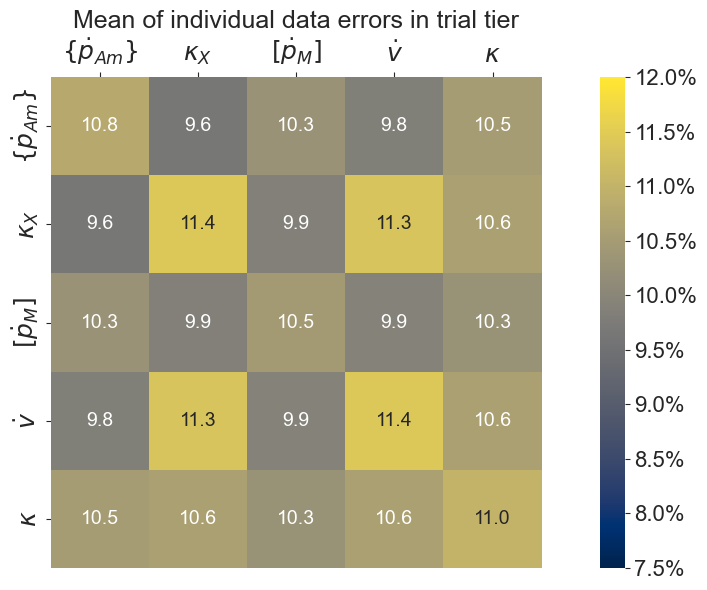

In [25]:
trial_tier_errors_heatmap_df = pd.DataFrame(index=par_order, columns=par_order, dtype='float')
for i, par1 in enumerate(par_order):
    for j, par2 in enumerate(par_order):
        if j < i:
            continue
        if i == j:
            estim = par1
        else:
            estim = ' '.join(sorted([par1, par2], key=lambda x: par_order.index(x)))
        trial_tier_errors_heatmap_df.loc[par1, par2] = trial_ind_data_errors_df.loc[estim].mean(numeric_only=True)['avg'] * 100
        trial_tier_errors_heatmap_df.loc[par2, par1] = trial_tier_errors_heatmap_df.loc[par1, par2]
plot_heatmap(trial_tier_errors_heatmap_df, 'trial')

### Individual tier

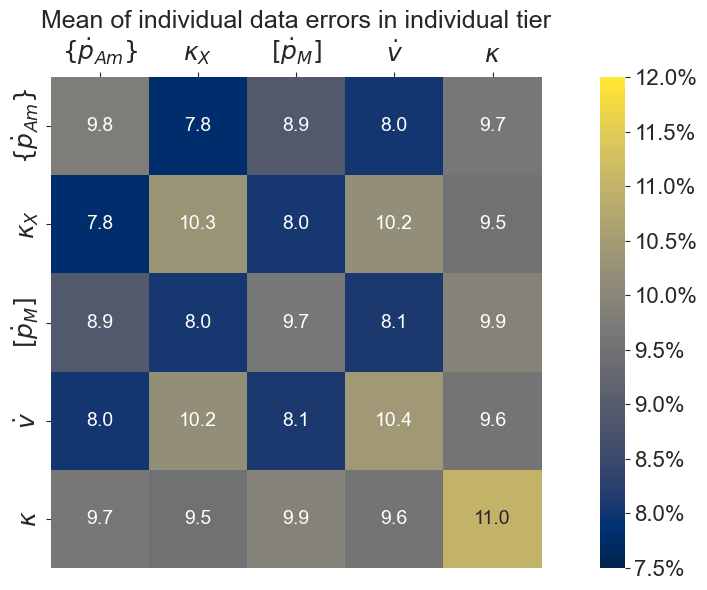

In [26]:
ind_tier_errors_heatmap_df = pd.DataFrame(index=par_order, columns=par_order, dtype='float')
for i, par1 in enumerate(par_order):
    for j, par2 in enumerate(par_order):
        if j < i:
            continue
        if i == j:
            estim = par1
        else:
            estim = ' '.join(sorted([par1, par2], key=lambda x: par_order.index(x)))
        ind_tier_errors_heatmap_df.loc[par1, par2] = individual_ind_data_errors_df.loc[estim].mean(numeric_only=True)['avg'] * 100
        ind_tier_errors_heatmap_df.loc[par2, par1] = ind_tier_errors_heatmap_df.loc[par1, par2]
plot_heatmap(ind_tier_errors_heatmap_df, 'individual')

## Model predictions

In [27]:
def build_cow(estim, ind_id):
    tier_pars = estim.split()
    if tier_pars != trial_tier.tier_pars:
        multitier.set_tier_parameters('trial', tier_pars)
        trial_tier.output_folder = f"{multitier.output_folder}/trial/{' '.join(tier_pars)}"
        trial_tier.load_results()
    if tier_pars != individual_tier.tier_pars:
        multitier.set_tier_parameters('individual', tier_pars)
        individual_tier.output_folder = f"{multitier.output_folder}/individual/{' '.join(tier_pars)}"
        individual_tier.load_results()
    pars_dict = multitier.get_full_pars_dict('individual', ind_id, include_tier=True)
    pars_dict.update(non_estimated_pars)
    #print(pars_dict)
    cow = pet.Pet(**pars_dict)
    return cow

In [28]:
def viz_ind_step_predictions(estim, ind_id):
    # Get data
    ds_name = multitier.data.get_data_source_of_ind(ind_id, 'tW')[0]
    wds = multitier.data.data_sources[ds_name]
    weight_data, initial_date, initial_weight = wds.get_data(ind_id)
    ds_name = multitier.data.get_data_source_of_ind(ind_id, 'tJX')[0]
    fids = multitier.data.data_sources[ds_name]
    feed_intake_data, initial_date, initial_weight = fids.get_data(ind_id)

    
    W_i = weight_data.iloc[0]['weight'] * 1000
    t = np.linspace(weight_data.iloc[0]['age'], weight_data.iloc[-1]['age'])
    
    # Get DEB model
    cow = build_cow(estim, ind_id)
    
    print(f"Individual {ind_id} belongs to the {multitier.ind_tiers.loc[ind_id, 'trial']}.")
    
    # Plotting
    fig, axes = plt.subplots(1,2, figsize=(12, 5), tight_layout=True)
    # Weight
    ax = axes[0]
    ax.grid(zorder=1)
    ax.set_xlabel('Age [d]', fontsize=14)
    ax.set_ylabel("Weight [kg]", fontsize=14)
    sns.scatterplot(data=weight_data, x='age', y='weight', ax=ax, zorder=2)
    ax.plot(t, formulae.weight_curve(cow, t, W_i, t0=t[0])/1000, 'r', label='DEB model', zorder=2)
    ax.legend()
    # Feed intake
    ax = axes[1]
    ax.grid()
    ax.set_xlabel('Age [d]', fontsize=14)
    ax.set_ylabel("Feed Intake [kg/d]", fontsize=14)
    sns.scatterplot(data=feed_intake_data, x='age', y='dry_intake', ax=ax, zorder=2)
    ax.plot(t, formulae.feed_intake_curve(cow, t, W_i, t0=t[0])/1000, 'r', label='DEB model', zorder=2)
    ax.legend()
    
    if save:
        fig.savefig(f"{fig_save_folder}/Model Predictions/weight_feed_{estim}_{ind_id}.pdf")
    

estim_selector = widgets.Dropdown(options=individual_tier_estim_list, value='p_Am kap_X', description='Individual parameters:', disabled=False)
ind_selector = widgets.Dropdown(options=multitier.data.individuals, value='PT324096615', description='Individual ID:', disabled=False)
widgets.interactive(viz_ind_step_predictions, estim=estim_selector, ind_id=ind_selector)

interactive(children=(Dropdown(description='Individual parameters:', index=5, options=('p_Am', 'kap_X', 'p_M',…

### $\{ \dot{p}_{Am} \}$ and $\kappa_X$ Scatterplot and Histograms

In [29]:
sns.set_style('ticks')
def plot_scatter_hist_of_ind_pars(estim):
    xpar, ypar = estim.split()
    hue = 'trial'
    estim_ind_pars = individual_pars_df.loc[estim].dropna(axis=1).join(multitier.ind_tiers['trial'])
    estim_trial_pars = trial_pars_df.loc[estim].dropna(axis=1)

    fig = plt.figure(tight_layout=True, figsize=(12, 7))
    gs = gridspec.GridSpec(2,3)
    ax = fig.add_subplot(gs[0:2, 0:2])
    ax.grid(zorder=1)

    sns.scatterplot(data=estim_ind_pars, x=xpar,y=ypar, ax=ax, s=100, hue=hue, zorder=2)
    ax.set_xlabel(f"{par_descriptions_en[xpar]} ${tex_par_symbols[xpar]}$ [${tex_par_units[xpar]}$]", fontsize=14)
    ax.set_ylabel(f"{par_descriptions_en[ypar]} ${tex_par_symbols[ypar]}$ [${tex_par_units[ypar]}$]", fontsize=14)
    
    # 2020 trial params
    for year, i, edgecolor in zip((2020,2021),(0,1),('blue', 'orange')):
        label = f'{year} trial parameters'
        ax.scatter(estim_trial_pars.loc[f"Trial{year}", xpar], estim_trial_pars.loc[f"Trial{year}", ypar], 
                   c=plt.cm.tab10.colors[i], marker='D', label=label, edgecolor='black', s=100, zorder=2)
        #plt.text(ps_pars_df.loc[estim, f"{xpar}_{year}"], ps_pars_df.loc[estim, f"{ypar}_{year}"], label, fontsize=12, ha='right', va='bottom')
    ax.scatter(breed_pars_df[xpar], breed_pars_df[ypar], c=plt.cm.tab10.colors[2], marker='h', label='Breed parameters', edgecolor='black', s=150, zorder=2)    
    
    legend = ax.legend()
    legend.texts[0].set_text('Ind. pars. for 2020 trial')
    legend.texts[1].set_text('Ind. pars. for 2021 trial')

    # Histograms
    for i, par in enumerate((xpar, ypar)):
        ax = fig.add_subplot(gs[i, 2])
        sns.histplot(data=estim_ind_pars, x=par, ax=ax, hue=hue, multiple='layer', edgecolor='black')
        ax.set_xlabel(f"${tex_par_symbols[par]}$ [${tex_par_units[par]}$]", fontsize=12)
        ax.set_ylabel("")
        for j, year in enumerate((2020, 2021)):
            ax.axvline(x=estim_trial_pars.loc[f"Trial{year}", par], color=plt.cm.tab10.colors[j], linestyle='--', linewidth=2, markeredgecolor='black')
        ax.axvline(x=breed_pars_df[par], color=plt.cm.tab10.colors[2], linestyle='--', linewidth=2)
        ax.get_legend().remove()
        
    if save:
        fig.savefig(f"{fig_save_folder}/{xpar}_{ypar}_scatter_dist_all_tiers.pdf", transparent=True)
    

estim_selector = widgets.Dropdown(options=individual_tier_estim_list, value='p_Am kap_X', description='Individual parameters:', disabled=False)
widgets.interactive(plot_scatter_hist_of_ind_pars, estim=estim_selector)


interactive(children=(Dropdown(description='Individual parameters:', index=5, options=('p_Am', 'kap_X', 'p_M',…